## Import Libraries

In [1]:
%matplotlib inline

import pandas as pd # to manage data frames and reading csv files
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
import seaborn as sns
sns.set_style("darkgrid")

## Set Global Variables

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have a 28x28 matrix to describe each digit
hidden_nodes = 250
output_nodes = 10

learning_rate = 0.2
batch_size = 3 # increase this if you want batch gradient descent

# epochs is the number of training iterations 
epochs = 20

# datasets to read
# you can change these when trying out other datasets
train_file = "mnist_train.csv"
test_file = "mnist_test.csv"

## Get the MNIST Data into a Frame

In [4]:
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

y_train_all =  pd.get_dummies(df_orig_train[0]).values
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)

y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB
(60000, 10)
(60000, 784)
(10000, 10)
(10000, 784)


## Helper Functions to Preprocess the Data

In [5]:
# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 1500  # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)

X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)

#preprocessing steps
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)

test_sample_size = 100 
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)

X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)

(1500, 10)
(1500, 784)
(1500, 10)
(100, 10)
(100, 784)


## Helper functions for Evaluation

In [6]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy

## Helper classes for activations

In [7]:
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
    def backward(self, inputs):
        self.output = np.greater(inputs, 0).astype(int) # inputs > 0 then convert bools to int
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))

## Class Layer_dense to build layers

In [8]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, learningrate=0.01, activation='sigmoid'):
        
        self.weights = np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        print(self.weights.shape)
        self.biases = np.zeros((1, n_neurons))
       
        self.lr = learningrate
        self.activate=activation  
        
    def forward(self, inputs):
        self.in_values = inputs
        self.layer_input = np.dot(inputs , self.weights) + self.biases
        self.activation()
    
    def activation(self):
        if self.activate == 'sigmoid':
            a = Activation_Sigmoid()
            self.layer_output = a.forward(self.layer_input)
            
           
    def del_activation(self):
        if self.activate == 'sigmoid':
            del_a = Activation_Sigmoid()
            self.del_layer_output =  del_a.backward(del_a.forward(self.layer_input))
      
    def backward(self, delta_in, weights_in, targets=None, output_layer=False):
        self.del_activation()
        if output_layer:
            self.layer_error = self.layer_output - targets
            self.layer_delta = self.layer_error * self.del_layer_output
        else:          
            self.layer_error = np.dot(delta_in, weights_in.T)
            self.layer_delta = self.layer_error * self.del_layer_output
        
    def weight_update(self, prev_layer_output):
        # print("prev_layer_output.T.shape: "+str(prev_layer_output.T.shape))
        # print("self.layer_delta.shape: "+str(self.layer_delta.shape))
        N = self.layer_delta.shape[0]
        weights_update = np.dot(prev_layer_output.T, self.layer_delta) / N
        # print(weights_update.shape)
        self.weights -= self.lr * weights_update
        biases_update = np.mean(self.layer_delta, axis=0, keepdims=True)
        # print("biases_update.shape: "+ str(biases_update.shape))
        # print("self.biases.shape: "+ str(self.biases.shape))
        self.biases -= self.lr * biases_update

In [9]:
layer1 = Layer_Dense(784, 200) # set the weight matrix dimensions (input nodes x hidden nodes)
output = Layer_Dense(200, 10) # set the weight matrix dimensions (hidden nodes x output nodes)

# maintain a dataframe to keep track of the network error
monitoring = {}
monitoring['mean_squared_error'] = []
monitoring['accuracy'] = []

# iterate and update weights at each epoch
for epoch in range(100):
    layer1.forward(X_train)
    # print('layer1 output \n' ,layer1.layer_output.shape)
    output.forward(layer1.layer_output)
    # print('layer output  \n', output.layer_output.shape)

    # train metrics
    pred = output.layer_output
    mse = mean_squared_error(pred, y_train)
    acc = accuracy(output.layer_output, y_train)
    monitoring['mean_squared_error'].append(mse)
    monitoring['accuracy'].append(acc)

    # backprop through the layers 
    output.backward(None, None, y_train, True)
    # print('layer out delta  \n', output.layer_delta.shape)
    layer1.backward(output.layer_delta, output.weights)
    # print('layer1 delta  \n', layer1.layer_delta.shape)

    # update all the layer weights
    output.weight_update(layer1.layer_output)
    # print('layer weights  \n', output.weights.shape)
    layer1.weight_update(X_train)
    # print('layer weights  \n', layer1.weights.shape)

monitoring_df = pd.DataFrame(monitoring)   
monitoring_df

(784, 200)
(200, 10)


,mean_squared_error,accuracy
0,0.147886,0.119333
1,0.141949,0.119333
2,0.136223,0.119333
3,0.130721,0.120000
4,0.125453,0.121333
...,...,...
95,0.044949,0.210000
96,0.044901,0.211333
97,0.044854,0.211333
98,0.044808,0.214667


## Build ANN Class

In [10]:
class ANN():
    def __init__(self, ouput_layer, hidden_layer, batch_size = 10):
        self.output = ouput_layer
        self.layer1 = hidden_layer
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, lr):
        self.layer1.lr = lr
        self.output.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x)
                # print('layer1 output \n' ,layer1.layer_output.shape)
                self.output.forward(self.layer1.layer_output)
                # print('layer output  \n', output.layer_output.shape)

                # backprop through the layers 
                self.output.backward(None, None, batch_y, True)
                # print('layer out delta  \n', output.layer_delta.shape)
                self.layer1.backward(self.output.layer_delta, self.output.weights)
                # print('layer1 delta  \n', layer1.layer_delta.shape)

                # update all the layer weights
                self.output.weight_update(self.layer1.layer_output)
                # print('layer weights  \n', output.weights.shape)
                self.layer1.weight_update(batch_x)
                # print('layer weights  \n', layer1.weights.shape)
            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x)
        self.output.forward(self.layer1.layer_output)
        return self.output.layer_output

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)

## Train ANN

In [11]:
np.random.seed(42)

# set other hyperparameters
batch_size = 20
epochs = 10
lr = 0.3

# configure the layers
hidden = Layer_Dense(784,200)
output = Layer_Dense(200,10)

# create an ANN model
ann = ANN(output, hidden, batch_size)

# train the ANN model with training data
train_performance = ann.train(X_train, y_train, epochs, lr)

train_performance

(784, 200)
(200, 10)


,mean_squared_error,accuracy
0,0.041305,0.261333
1,0.037684,0.413333
2,0.032928,0.566667
3,0.028472,0.638000
4,0.024884,0.702667
5,0.022115,0.763333
6,0.019913,0.811333
7,0.018117,0.840667
8,0.016636,0.856000
9,0.015409,0.862667


## Plot Model error and accuracy

<AxesSubplot:title={'center':'Accuracy'}>

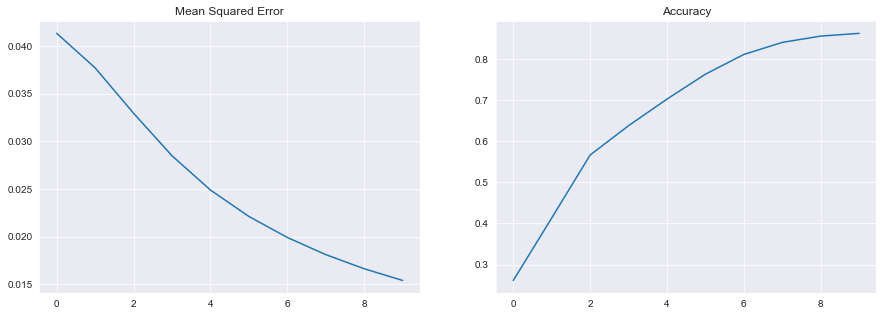

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
train_performance.mean_squared_error.plot(ax=axes[0], title="Mean Squared Error")

train_performance.accuracy.plot(ax=axes[1], title="Accuracy") 
#plt.savefig('train_performance.png', dpi=300) # uncomment to save this plot

## Perfomance on test data

In [13]:
print(X_test.shape)
print(y_test.shape)
test_performance = ann.test(X_test, y_test)
test_performance

(100, 784)
(100, 10)


,mean_squared_error,accuracy
0,0.015389,0.85


## Modifying Hyperparameters

#### Epochs

In [ ]:
np.random.seed(42)

# set other hyperparameters
batch_size = [1, 10, 20, 40, 100]
epochs = 10
lr = 0.3

batch_accuracies = []

for sizes in batch_size:
    # configure the layers
    hidden = Layer_Dense(784,200)
    output = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output, hidden, batch_size)

    # train the ANN model with training data
    train_performance = ann.train(X_train, y_train, epochs, lr)
    train_performance




## Exploring DIfferent values of a hyperparamater

In [20]:
print("This will take a lot of moments ...")
ann_list = []
ann_epochs = []
ann_lr = []
train_results_list = []
epochs = [1, 10, 20, 30, 60, 100]
learning_rates = [0.1, 0.3, 0.5, 0.7, 1]
batch_sizes = [1, 20, 100, 200, 500, len(X_train)]


for batch_size in batch_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, hidden_layer, batch_size) # create a new ANN model with a specific batch size
    train_performance = ann.train(X_train, y_train, epochs=20, lr=0.3) # train the model

    train_results_list.append(train_performance)
    ann_list.append(ann) # maintain each ANN model in a list
    
for epoch in epochs:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, hidden_layer, 20) # create a new ANN model with a specific epoch
    train_performance = ann.train(X_train, y_train, epochs=epoch, lr=0.3) # train the model

    train_results_list.append(train_performance)
    ann_epochs.append(ann) # maintain each ANN model in a list
    
for learning_rate in learning_rates:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, hidden_layer, 20) # create a new ANN model with a specific learning rate
    train_performance = ann.train(X_train, y_train, epochs=20, lr=learning_rate) # train the model

    train_results_list.append(train_performance)
    ann_lr.append(ann) # maintain each ANN model in a list

    
print('completed')

This will take a lot of moments ...
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
completed


## Gather Results for each ANN Analysis

### Batch Sizes

In [36]:
test_results_list = []

for model in ann_list: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list.append((mse[0], acc[0]))

    pass
pass

print ("Batch Size Mean Squared Error and Accuracy Results \n {}".format(test_results_list))

df_batch_results = pd.DataFrame(test_results_list, columns=['mean_squared_error','accuracy'], index=batch_sizes)
df_batch_results.head()

Batch Size Mean Squared Error and Accuracy Results 
 [(0.005961326713288951, 0.91), (0.010613642023635976, 0.9), (0.02777806742217028, 0.75), (0.036435742123484605, 0.48), (0.041451512386853066, 0.39), (0.04247694844136031, 0.33)]


,mean_squared_error,accuracy
1,0.005961,0.91
20,0.010614,0.90
100,0.027778,0.75
200,0.036436,0.48
500,0.041452,0.39


### Epochs

In [37]:
test_results_list_epochs = []

for model in ann_epochs: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list_epochs.append((mse[0], acc[0]))

    pass
pass

print ("Epochs Mean Squared Error and Accuracy Results \n {}".format(test_results_list_epochs))

df_batch_results = pd.DataFrame(test_results_list_epochs, columns=['mean_squared_error','accuracy'], index=epochs)
df_batch_results.head()

Epochs Mean Squared Error and Accuracy Results 
 [(0.04161093110918696, 0.28), (0.015336784673219084, 0.85), (0.010599269721739937, 0.89), (0.009316743226206356, 0.9), (0.007577996234570887, 0.9), (0.006548247574895097, 0.93)]


,mean_squared_error,accuracy
1,0.041611,0.28
10,0.015337,0.85
20,0.010599,0.89
30,0.009317,0.90
60,0.007578,0.90


### Learning rates

In [38]:
test_results_list_lr = []

for model in ann_lr: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list_lr.append((mse[0], acc[0]))

    pass
pass

print ("Learning Rate Mean Squared Error and Accuracy Results \n {}".format(test_results_list_lr))

df_batch_results = pd.DataFrame(test_results_list_lr, columns=['mean_squared_error','accuracy'], index=learning_rates)
df_batch_results.head()

Learning Rate Mean Squared Error and Accuracy Results 
 [(0.01968501389430905, 0.81), (0.010609263794293658, 0.89), (0.009210905333060989, 0.89), (0.008305828278778083, 0.9), (0.007421544655755668, 0.91)]


,mean_squared_error,accuracy
0.1,0.019685,0.81
0.3,0.010609,0.89
0.5,0.009211,0.89
0.7,0.008306,0.90
1.0,0.007422,0.91


## Create Bar charts to analyse impact of hyperparameters

#### Batch Size

Text(0.5, 1.0, 'Accuracy')

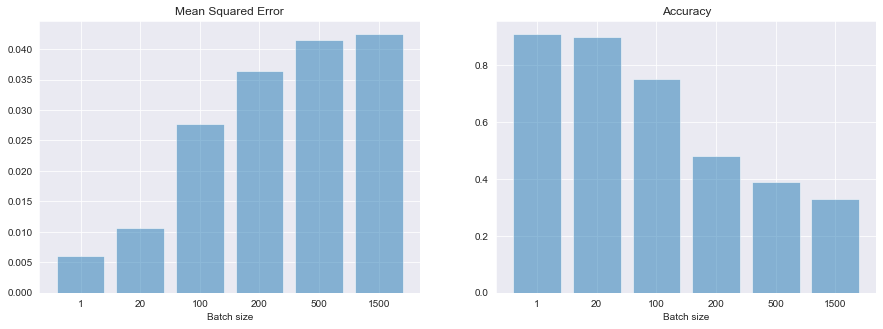

In [39]:
objects = batch_sizes
performance = test_results_list

# plot performances bars
fig, axes = plt.subplots(1, 2, figsize=(15,5))
y_pos = np.arange(len(objects))
# get mean squared error from performance
model_mse = [x[0] for x in performance]
axes[0].bar(y_pos, model_mse, align='center', alpha=0.5)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Batch size')
axes[0].set_title('Mean Squared Error')

# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes[1].bar(y_pos, model_acc, align='center', alpha=0.5)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Batch size')
axes[1].set_title('Accuracy')

#### Epochs

Text(0.5, 1.0, 'Accuracy')

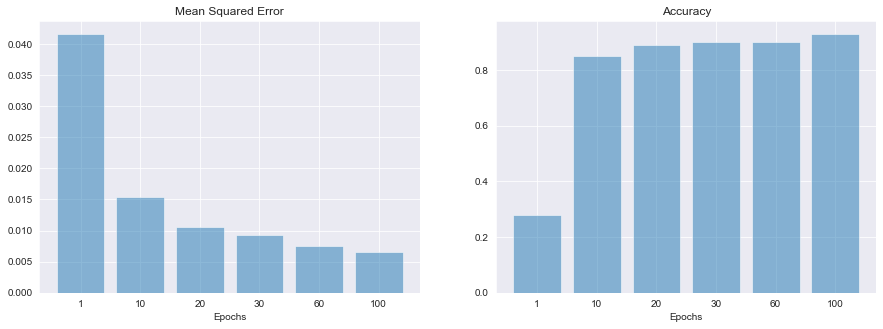

In [40]:
objects = epochs
performance = test_results_list_epochs

# plot performances bars
fig, axes = plt.subplots(1, 2, figsize=(15,5))
y_pos = np.arange(len(objects))
# get mean squared error from performance
model_mse = [x[0] for x in performance]
axes[0].bar(y_pos, model_mse, align='center', alpha=0.5)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Epochs')
axes[0].set_title('Mean Squared Error')

# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes[1].bar(y_pos, model_acc, align='center', alpha=0.5)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Epochs')
axes[1].set_title('Accuracy')

#### Learning Rates

Text(0.5, 1.0, 'Accuracy')

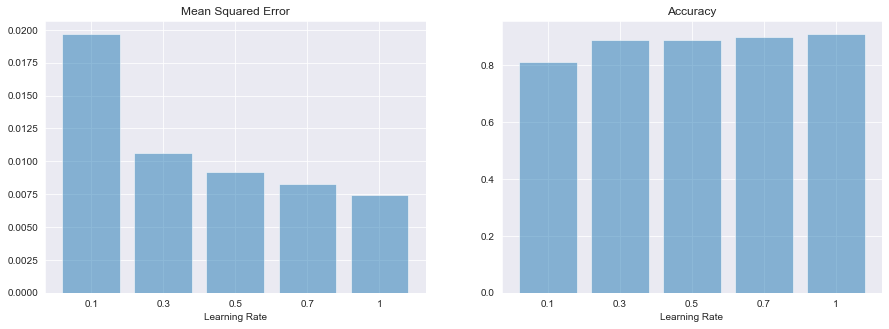

In [41]:
objects = learning_rates
performance = test_results_list_lr

# plot performances bars
fig, axes = plt.subplots(1, 2, figsize=(15,5))
y_pos = np.arange(len(objects))
# get mean squared error from performance
model_mse = [x[0] for x in performance]
axes[0].bar(y_pos, model_mse, align='center', alpha=0.5)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Learning Rate')
axes[0].set_title('Mean Squared Error')

# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes[1].bar(y_pos, model_acc, align='center', alpha=0.5)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Learning Rate')
axes[1].set_title('Accuracy')

## Study the Impact of varying two hyper paramaters

In [18]:
# Try different configurations of hidden layer and batch size
print("Percentage of training data used: ", (len(y_train)/len(y_train_all)) * 100)

print("This will take a few moments ...")
train_results_list = []
ann_list = []
batch_sizes = [1, 20, 100, 200, 500, len(y_train)]  # lets try six different configurations of batch sizes
hidden_nodes = [200, 5]  # two different configurations of hidden node layer

# lets create the set of modesl
for hidden in hidden_nodes:
    ann_list_element = [] # first set of nets with a given hidden node size
    for batch in batch_sizes:
        # configure the layers
        hidden_layer = Layer_Dense(784, hidden)
        output_layer = Layer_Dense(hidden, 10)
        ann_ = ANN(output_layer, hidden_layer, batch) # create a new ANN model with a specific batch size
        train_performance = ann_.train(X_train, y_train, epochs=20, lr=0.3) # train the model

        train_results_list.append(train_performance)
        ann_list_element.append(ann_) # maintain each ANN model in a list
 
        pass
    
    ann_list.append(ann_list_element)# now append the set of models 
    pass

#lets test the models 
model_results = []
model_result_element = []

for model1 in ann_list:
    model_result_element = []
    
    for model2 in model1:
        df_test_result = model2.test(X_test, y_test)
        mse=df_test_result['mean_squared_error'].values
        acc=df_test_result['accuracy'].values

        model_result_element.append((mse[0], acc[0]))
        pass
    model_results.append(model_result_element)
    pass

print('completed')

Percentage of training data used:  2.5
This will take a few moments ...
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 5)
(5, 10)
(784, 5)
(5, 10)
(784, 5)
(5, 10)
(784, 5)
(5, 10)
(784, 5)
(5, 10)
(784, 5)
(5, 10)
completed


## Plot the results of hidden nodes vs batch size

Text(0.5, 1.0, 'Mean Squared Average')

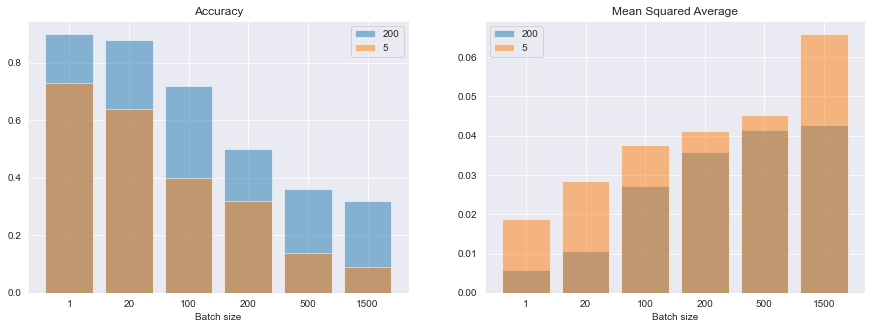

In [19]:
objects = batch_sizes

fig, axes = plt.subplots(1, 2, figsize=(15,5))

for result in model_results:
    performance_mse = [x[0] for x in result]  # mean squared error
    performance_acc = [x[1] for x in result]  # accuracy
    axes[0].bar(y_pos, performance_acc, align='center', alpha=0.5 )  # add accuracy to plot
    axes[1].bar(y_pos, performance_mse, align='center', alpha=0.5 )  #  add mean squared error to plot

y_pos = np.arange(len(objects))
axes[0].legend(hidden_nodes)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Batch size')
axes[0].set_title('Accuracy')

axes[1].legend(hidden_nodes)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Batch size')
axes[1].set_title('Mean Squared Average')